In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stat
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
from IPython.display import HTML
style = "<style>h2{color: #FF756D; font-size: 400%} h3 {color: #85DE77;font-size: 200%;} h4 {color: #FFF49C; font-size: 150%} p {color:#F9FFCB }</style>"
print('Just stylising the markdowns')
HTML(style)

Just stylising the markdowns


## Reading in train and test data and finding out what we have here
### Colour scheme for markdown:
Coral Reef (#FF756D), Pastel Yellow (#FFF49C), Conditioner (#F9FFCB) and Pastel Green (#85DE77)


In [185]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.shape
df_test_id = df_test['Id']

#### There are 81 features! How should I select and process them for the model?

## Preprocessing
### Finding out missing data and data types

In [4]:
def missingData(df):
    count = df.isnull().sum()
    normalised = df.isnull().sum()/df.isnull().count()*100
    print('There are {} columns with missing data'.format((count!=0).sum()))
    normalisedList = normalised.sort_values(ascending = False)[count!= 0]
    
    return normalisedList

missingTraining = missingData(df).rename('Train')
missingTest = missingData(df_test).rename('Test')
missingTraining

There are 19 columns with missing data
There are 33 columns with missing data


PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Name: Train, dtype: float64

## Comparing missing data from Train and Test sets

In [5]:
df_missing = pd.merge(missingTraining,missingTest, 
                      how = 'outer',left_index= True, right_index = True)
(df_missing.sort_values(by = 'Test', ascending = False)
 .loc[df_missing['Test']>10])

,Train,Test
PoolQC,99.520548,99.794380
MiscFeature,96.301370,96.504455
Alley,93.767123,92.666210
Fence,80.753425,80.123372
FireplaceQu,47.260274,50.034270
LotFrontage,17.739726,15.558602


#### Consider dropping columns that are missing in both sets in large numbers
(arbitrary cut off at 10%)

<font color = #79D2E6>While there is no doubt that some of these features affect the selling price of the house (like having a pool, or an elevator at home), integrating it into our model will make it ungeneralisable! Hence, the decision to drop all pool related and misc features, alley type and fence types don't seem to provide valuable insight either. About 50% of the cases do not have fireplaces, it seems, there is another feature that gives the number of fireplaces, I guess it's OK to keep that and remove the fireplacequality data.
    
<font color = #79D2E6>We want common data that is generalisable to most/all data! If the prediction for house with pools become inaccurate, it is a cost to pay, I guess.
</font>

In [6]:
dropList = list(df_missing.index[df_missing['Test']>10])
dropList

['Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'MiscFeature', 'PoolQC']

In [7]:
df.FireplaceQu.fillna('na', inplace = True)
fireplace = pd.get_dummies(df.FireplaceQu)
fireplace.corrwith(df.SalePrice)

Ex    0.255239
Fa   -0.026086
Gd    0.339329
Po   -0.075916
TA    0.163147
na   -0.471908
dtype: float64

#### After exploring a little, maybe it is best to leave such sparse data in. <font color= red>As a principle: do not ignore data unless there is good evidence to do so.</font> Leave it to regularisation to remove useless features!

## Start filling data up!

In [8]:
df.dtypes[missingTraining.index]

PoolQC           object
MiscFeature      object
Alley            object
Fence            object
FireplaceQu      object
LotFrontage     float64
GarageCond       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
BsmtExposure     object
BsmtFinType2     object
BsmtFinType1     object
BsmtCond         object
BsmtQual         object
MasVnrArea      float64
MasVnrType       object
Electrical       object
dtype: object

In [9]:
def fillWithNa(df):
    df.fillna('NA',inplace = True)
    return df
def fillWithMean(df):
    df.fillna(df.mean(),inplace = True)
    return df
def fillWith0(df):
    df.fillna(0, inplace = True)
    return df

Much of the data are Nan because they do not have the feature that is required e.g. no basement or garage. The most accurate way to fill will be to use Na. There are features that specify the year the feature was built: minmaxscaling should scale the item correctly to reflect the age. 

1. Fill categories up with Na
2. Fill area up with 0
3. Fll year built with mean

In [10]:
areaFeatures = ['LotFrontage','MasVnrArea']
categoryFeatures = missingTraining.index[df.dtypes[missingTraining.index] != np.number]
yearBltFeature = ['GarageYrBlt']

In [11]:
df[categoryFeatures] = fillWithNa(df.loc[:,categoryFeatures])
df[yearBltFeature] = fillWithMean(df[yearBltFeature])
df[areaFeatures] = fillWith0(df[areaFeatures])
df.columns[df.isnull().sum() != 0]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Index([], dtype='object')

## Processing Continuous and Categorical data

In [12]:
continuous = df.columns[df.dtypes != object]
categorical = df.columns[df.dtypes == object]
featureTypes = pd.DataFrame([continuous,categorical], index = ['Continuous','Categorical'])
featureTypes.T

,Continuous,Categorical
0,Id,MSZoning
1,MSSubClass,Street
2,LotFrontage,Alley
3,LotArea,LotShape
4,OverallQual,LandContour
5,OverallCond,Utilities
6,YearBuilt,LotConfig
7,YearRemodAdd,LandSlope
8,MasVnrArea,Neighborhood
9,BsmtFinSF1,Condition1


In [13]:
df.MSSubClass.dtype

dtype('int64')

In [14]:
dropColumns = ['Id']
contToCat = ['MoSold','MSSubClass']
cat = ['category']*2
contToCat = dict(zip(contToCat,cat))
df = df.astype(contToCat)
df = df.drop(dropColumns, axis = 1)

In [127]:
len(df.columns)

81

### Trying to visualize the distribution of Sale Price

In [16]:
df.MoSold.value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

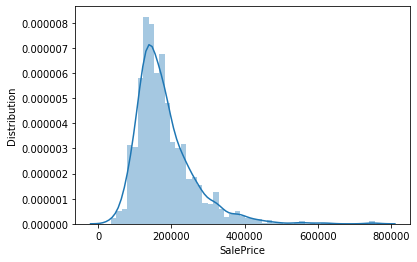

In [17]:
sns.distplot(df.SalePrice)
plt.ylabel('Distribution')
plt.show()

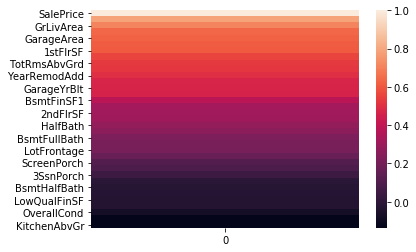

In [18]:
corr = pd.DataFrame(df.corrwith(df.SalePrice).sort_values(ascending = False))
sns.heatmap(corr)
plt.show()

In [19]:
corr.head()

,0
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431


### Visualising the relationship of sale price and some features

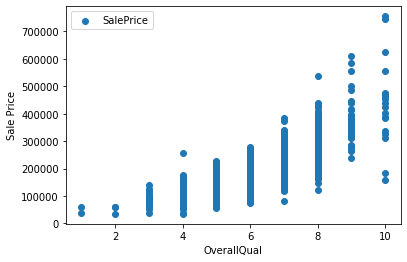

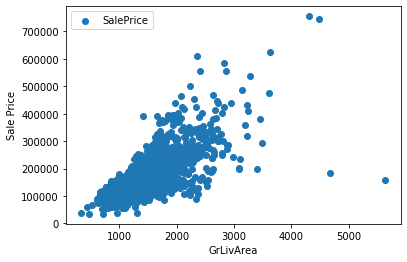

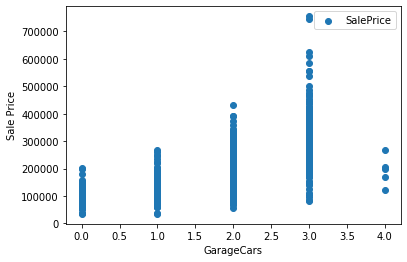

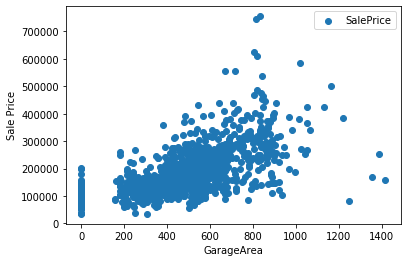

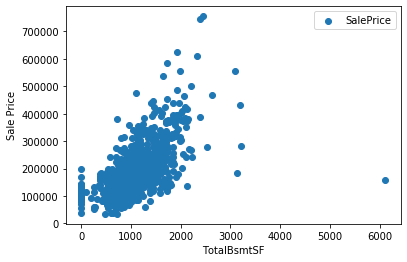

In [20]:
for feat in corr[1:6].index:
    
    plt.scatter(df[feat],df.SalePrice, label = 'SalePrice')
    plt.xlabel(feat)
    plt.ylabel('Sale Price')
    plt.legend()
    plt.show()
    

### Seems to be a linear relationship with the top few correlated features! 
(one of the assumptions of using a linear regression)

## Starting to process data for ML
### first with one hot encoding (get dummies)

In [21]:
df_binary = pd.get_dummies(df)
df_binary.shape

(1460, 330)

Now we have 330 columns!

In [68]:
X = df_binary.loc[:, df_binary.columns != 'SalePrice']
y = df_binary['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,np.log(y))

In [141]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Features split and scaled, ready to train model

In [142]:
model_1 = LinearRegression().fit(X_train_scaled, y_train)
def train_test_score(model, X_train, y_train, X_test, y_test):
    print('Training score: {}'.format(model.score(X_train,y_train)))
    print('Test score: {}'.format(model.score(X_test,y_test)))
    return None

In [71]:
train_test_score(model_1, X_train_scaled,y_train, X_test_scaled, y_test)

Training score: 0.9510309873864816
Test score: -1.2363185785923143e+20


### Ridge Model!

In [143]:
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha = 1).fit(X_train_scaled,y_train)
train_test_score(model_ridge, X_train_scaled,y_train, X_test_scaled, y_test)
print('Number of non-zero features: {}'
     .format(np.sum(model_ridge.coef_ != 0)))

slice = np.argsort(abs(model_ridge.coef_))[-10:]
importantFeats = [list(X_train)[index] for index in slice]
importantFeats

Training score: 0.9418051517552297
Test score: 0.8675128980070479
Number of non-zero features: 325


['2ndFlrSF',
 'PoolQC_Gd',
 'GarageCars',
 'MSZoning_C (all)',
 'OverallCond',
 'Condition2_PosN',
 '1stFlrSF',
 'GrLivArea',
 'OverallQual',
 'RoofMatl_ClyTile']

In [27]:
len(list(X_train_scaled))
len(list(X_train))
len(model_ridge.coef_)
featCoefs = list(zip(list(X_train),model_ridge.coef_))

'''for item in sorted(featCoefs, key = lambda item: abs(item[1])):
    print(item[0],item[1])'''
    
sorted(featCoefs, key = lambda item: abs(item[1]), reverse = True)[0:10]

[('Condition2_PosN', -0.6095191790253125),
 ('GrLivArea', 0.3164691530286499),
 ('1stFlrSF', 0.31546288146712),
 ('MSZoning_C (all)', -0.29289827954793324),
 ('LotArea', 0.2592278934458431),
 ('OverallQual', 0.2543052542858536),
 ('OverallCond', 0.24261313709343105),
 ('2ndFlrSF', 0.22104723162761575),
 ('TotalBsmtSF', 0.214304665355968),
 ('Condition2_Feedr', 0.1861832254101792)]

### Lasso model!

In [42]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha= 0.0001, max_iter = 10000).fit(X_train_scaled,y_train)
train_test_score(model_lasso, X_train_scaled,y_train, X_test_scaled, y_test)
print('Number of non-zero features: {}'
     .format(np.sum(model_lasso.coef_ != 0)))

Training score: 0.9536524227656589
Test score: 0.7276164549215606
Number of non-zero features: 198


## Roof tile material has the highest coefficient?!
Try removing roofMatl and see how training goes

In [29]:
df2 = df.drop('RoofMatl', axis = 1)
df_noRoof = pd.get_dummies(df2)
df_noRoof.shape

(1460, 322)

In [52]:
X_noRoof = df_noRoof.loc[:, df_noRoof.columns != 'SalePrice']
y_noRoof = df_noRoof['SalePrice']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_noRoof,np.log(y_noRoof))
X_train1_scaled = scaler.fit_transform(X_train1)
X_test1_scaled = scaler.fit_transform(X_test1)

In [66]:
model_noRoof = Ridge().fit(X_train1_scaled,y_train1)
train_test_score(model_noRoof, X_train1_scaled,y_train1,X_test1_scaled,y_test1)
featCoefsNoRoof = list(zip(list(X_train1),model_noRoof.coef_))
sorted(featCoefsNoRoof, key = lambda item: abs(item[1]), reverse = True)[0:10]

Training score: 0.9378267105403275
Test score: 0.8745000817338722


[('OverallQual', 0.4320488412086543),
 ('MSZoning_C (all)', -0.3459861526502932),
 ('GrLivArea', 0.3351445619115192),
 ('1stFlrSF', 0.31158473862777364),
 ('Condition2_PosN', -0.2895915686904622),
 ('LotArea', 0.240412368625525),
 ('PoolQC_Gd', -0.22953892837688455),
 ('GarageCars', 0.22690338672630408),
 ('OverallCond', 0.21852847426498598),
 ('2ndFlrSF', 0.19753867328575375)]

### Seems like roof tile material is an essential feature in the predicting of house prices! who knew?
#### Exploring the data, just to make sure it's not a dud.

In [32]:
df.RoofMatl.value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Membran       1
Metal         1
Roll          1
Name: RoofMatl, dtype: int64

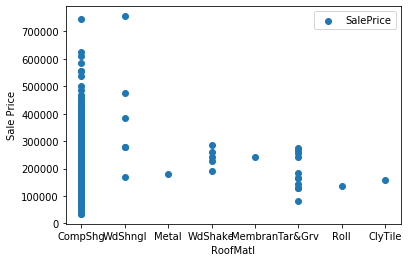

In [33]:
plt.scatter(df['RoofMatl'],df.SalePrice, label = 'SalePrice')
plt.xlabel('RoofMatl')
plt.ylabel('Sale Price')
plt.legend()
plt.show()

Only 1 house contains Clay/tile roof and 6 of wood shingles! they don't seem like they should have such a big weight! Esp when their prices aren't outliers! In general, the variance in this feature isn't very high..

Let's try combining the non CompShg categories into notCompShg (using a handy Pandas cookbook, the alternative will be to use pd.apply(lambda row: if row.RoofMatl == 'CompShg' return 'CompShg' else: return 'Not'

In [34]:
df['RoofMatlBin'] = 0
df.loc[df['RoofMatl'] == 'CompShg','RoofMatlBin'] = 'CompShg'
df.loc[df['RoofMatl'] != 'CompShg', 'RoofMatlBin'] = 'notCompShg'
df.RoofMatlBin.value_counts()
len(df.columns)

81

In [35]:
df3 = df.drop('RoofMatl', axis = 1)
df_roofBin = pd.get_dummies(df3)
df_roofBin.shape

(1460, 324)

In [64]:
X_roofBin = df_roofBin.loc[:, df_roofBin.columns != 'SalePrice']
y_roofBin = df_roofBin['SalePrice']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_roofBin,np.log(y_roofBin))
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.fit_transform(X_test2)

In [61]:
model_roofBin = Ridge().fit(X_train2_scaled,y_train2)
train_test_score(model_roofBin, X_train2_scaled, y_train2, X_test2_scaled, y_test2)
featCoefRoofBin = list(zip(list(X_train2),model_roofBin.coef_))
sorted(featCoefRoofBin, key = lambda item: abs(item[1]), reverse = True)[0:10]

Training score: 0.9381929203122157
Test score: 0.8581600995935263


[('Condition2_PosN', -0.4593863277306392),
 ('GrLivArea', 0.3661010723162318),
 ('OverallQual', 0.3614293655620713),
 ('1stFlrSF', 0.34771768800435826),
 ('PoolQC_Gd', -0.3246395994155994),
 ('MSZoning_C (all)', -0.26988358994716877),
 ('LotArea', 0.22917521755357598),
 ('PoolQC_Ex', 0.20670974373888854),
 ('OverallCond', 0.19861962791378965),
 ('TotRmsAbvGrd', 0.19289163493721076)]

### Final few steps: Cross Validation and grid search

In [89]:
from sklearn.model_selection import GridSearchCV

param_values = {'alpha': np.logspace(-3,2,6)}
cv_ridge = Ridge()
grid_ridge_acc = GridSearchCV(cv_ridge, param_grid = param_values, cv = 3)
grid_ridge_acc.fit(X_roofBin,y_roofBin)
print('Best alpha: {}'.format(grid_ridge_acc.best_params_))
print('Best score:{}'.format(grid_ridge_acc.best_score_))

Best alpha: {'alpha': 10.0}
Best score:0.8272138002552848


In [90]:
grid_ridge_acc.fit(X,y)
print('Best alpha: {}'.format(grid_ridge_acc.best_params_))
print('Best score:{}'.format(grid_ridge_acc.best_score_))

Best alpha: {'alpha': 10.0}
Best score:0.8312525867209881


In [91]:
grid_ridge_acc.fit(X_noRoof,y_noRoof)
print('Best alpha: {}'.format(grid_ridge_acc.best_params_))
print('Best score:{}'.format(grid_ridge_acc.best_score_))

Best alpha: {'alpha': 10.0}
Best score:0.8301720078378927


## Evaluation across 3 different versions of datasets give the same alpha score of 10 for ridge regression model

In [144]:
test_model = Ridge(alpha = 10)
X_scaled = scaler.fit_transform(X)
test_model.fit(X_scaled,y)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [106]:
df_test.dtypes[missingTest.index]

PoolQC           object
MiscFeature      object
Alley            object
Fence            object
FireplaceQu      object
LotFrontage     float64
GarageCond       object
GarageQual       object
GarageYrBlt     float64
GarageFinish     object
GarageType       object
BsmtCond         object
BsmtQual         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
MasVnrType       object
MasVnrArea      float64
MSZoning         object
BsmtHalfBath    float64
Utilities        object
Functional       object
BsmtFullBath    float64
BsmtFinSF2      float64
BsmtFinSF1      float64
Exterior2nd      object
BsmtUnfSF       float64
TotalBsmtSF     float64
SaleType         object
Exterior1st      object
KitchenQual      object
GarageArea      float64
GarageCars      float64
dtype: object

### Filled up the test data with zeroes and NA & preprocessed them.}

In [121]:
test_cat = missingTest.index[df_test.dtypes[missingTest.index] == object]
test_zero = missingTest.index[df_test.dtypes[missingTest.index] != object]
df_test[test_cat] = fillWithNa(df_test.loc[:,test_cat])
df_test[test_zero] = fillWith0(df_test[test_zero])
df_test.columns[df_test.isnull().sum() != 0]
df_test = df_test.astype(contToCat)
df_test = df_test.drop(dropColumns, axis = 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


KeyError: "['Id'] not found in axis"

In [135]:
df_test['RoofMatlBin'] = 0
df_test.loc[df_test['RoofMatl'] == 'CompShg','RoofMatlBin'] = 'CompShg'
df_test.loc[df_test['RoofMatl'] != 'CompShg', 'RoofMatlBin'] = 'notCompShg'

In [146]:
test_X = pd.get_dummies(df_test)

In [152]:
X.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=329)

In training but not in test

In [166]:
feats_to_add = list(X.columns.difference(test_X.columns))

In test but not in training

In [163]:
feats_to_drop = test_X.columns.difference(X.columns)

In [175]:
for feat in feats_to_add:
    test_X[feat] = 0

(1459, 340)

In [178]:
test_X = test_X.drop(feats_to_drop,axis = 1)
test_X.shape

(1459, 329)

In [180]:
scaled_test_X = scaler.fit_transform(test_X)

This indicates that there are categories in test that weren't in training. We can remove those that weren't in training and add 0 for those that do not exist in test

## Making prediction and creating CSV file

In [189]:
answer = pd.Series(test_model.predict(scaled_test_X),name = 'SalePrice')
df_answer = pd.concat([df_test_id,answer], axis = 1)
df_answer.to_csv(r'yourpathhere/namehere.csv',index = None)

# <font color = pink>Congratulations! You're finally done! RMSE of .32849! <font>

#### Big takeaway: maybe try filling and processing data together: both test and train, but try not to use mean or median that might be affected by test data.